In [13]:
# Instalação das bibliotecas
# NLTK (Natural Language Toolkit) --> análise linguística.
# VADER --> análise de sentimentos otimizada para textos de mídias sociais.
import sys
!{sys.executable} -m pip install nltk vaderSentiment tqdm
!{sys.executable} -m pip install scikit-learn


[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
# Importação das bibliotecas e download de recursos do NLTK (sem alterações)
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.auto import tqdm


# Download de todos os pacotes necessários do NLTK
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)
nltk.download('vader_lexicon', quiet=True)

# Configurações visuais para os gráficos
sns.set_style('whitegrid')
%matplotlib inline

# Inicializa o tqdm para integração com o pandas
tqdm.pandas()

In [15]:
# Carregamento dos dados

# Baixar o arquivo principal usando wget
# !wget -O dados_combinados.csv "https://raw.githubusercontent.com/Gabrielzzz7/news-appeal-analysis/refs/heads/main/dados_combinados.csv?token=GHSAT0AAAAAADEW5VP7Y5S4IROVX5LB2JUG2DKS5RQ"

df_main = pd.read_csv('dados_combinados.csv')
arquivo_rotulado = 'amostra_4_rotulada.csv'
df_rotulado = pd.read_csv(arquivo_rotulado)


# Preparação do df_main
df_main.dropna(subset=['title', 'label'], inplace=True)

# Para rodar com o dataset completo
fracao_para_prototipar = 0.1 # Use 10% do dataset
df_main = df_main.sample(frac=fracao_para_prototipar, random_state=42)

df_main.loc[:, 'label_numeric'] = df_main['label'].map({'true': 0, 'fake': 1})

print("\n--- Visão geral do Dataset Principal (lido localmente) ---")
print(df_main.head())

print("\n\n--- Visão geral do Dataset com Rótulos Humanos ---")
print(df_rotulado.head())


--- Visão geral do Dataset Principal (lido localmente) ---
                         id  \
4291   gossipcop-8734494756   
14922      gossipcop-842955   
19868      gossipcop-844164   
12669      gossipcop-920887   
12570      gossipcop-926989   

                                                news_url  \
4291   www.usmagazine.com/celebrity-news/news/will-bi...   
14922  https://www.usmagazine.com/celebrity-news/news...   
19868  https://www.upi.com/Entertainment_News/Movies/...   
12669  https://www.hollywoodreporter.com/live-feed/x-...   
12570  https://www.usatoday.com/story/life/tv/2018/12...   

                                                   title  \
4291   Will Bindi Irwin Get Married to Boyfriend Chan...   
14922  Bob Harper: Howard Stern Reached Out to Me Aft...   
19868  'Guardians of the Galaxy Vol. 2' cast play Gue...   
12669  'The X-Files': What Did Scully Whisper to Mulder?   
12570  'Today': Ratings show replacing Matt Lauer wit...   

                               

In [16]:
# Pré-processamento e Limpeza dos Textos

stop_words = set(stopwords.words('portuguese'))

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

print("Limpando textos do dataset principal:")
df_main['title_cleaned'] = df_main['title'].progress_apply(preprocess_text)

print("\nLimpando textos do dataset humano:")
df_rotulado['title_cleaned'] = df_rotulado['title'].progress_apply(preprocess_text)

print("\nPré-processamento concluído para ambos os datasets.")

Limpando textos do dataset principal:


100%|██████████| 2320/2320 [00:00<00:00, 12091.79it/s]



Limpando textos do dataset humano:


100%|██████████| 125/125 [00:00<00:00, 13117.69it/s]


Pré-processamento concluído para ambos os datasets.


In [ ]:
# Extração de Atributos

def count_pos_tags(text):
    tokens = word_tokenize(text, language='portuguese')
    tags = pos_tag(tokens)
    adjectives = len([word for word, tag in tags if tag.startswith('JJ')])
    adverbs = len([word for word, tag in tags if tag.startswith('RB')])
    return adjectives, adverbs

def get_vader_scores(text):
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(text)
    return scores['compound']

def extract_features(df):
    print("Extraindo contagem de pontuação...")
    df['exclamation_count'] = df['title'].str.count('!')
    df['question_mark_count'] = df['title'].str.count('\?')

    print("Contando tags morfossintáticas (adjetivos, advérbios)...")
    df[['adjectives', 'adverbs']] = df['title_cleaned'].progress_apply(lambda x: pd.Series(count_pos_tags(x)))

    print("Contando palavras e caracteres...")
    df['word_count'] = df['title_cleaned'].progress_apply(lambda x: len(x.split()))
    df['char_count'] = df['title_cleaned'].progress_apply(len)

    print("Analisando sentimento...")
    df['sentiment_compound'] = df['title_cleaned'].progress_apply(get_vader_scores)
    return df

# Aplicar a nova função de extração em ambos os DataFrames
print("--- Processando df_main ---")
df_main = extract_features(df_main)
print("\n--- Processando df_rotulado ---")
df_rotulado = extract_features(df_rotulado)

print("\nExtração de atributos concluída.")
# Mostrando os novos atributos no dataset humano como exemplo
print(df_rotulado[['title', 'exclamation_count', 'question_mark_count']].head())

<>:18: SyntaxWarning: invalid escape sequence '\?'
<>:18: SyntaxWarning: invalid escape sequence '\?'
C:\Users\gabri\AppData\Local\Temp\ipykernel_24716\2504977915.py:18: SyntaxWarning: invalid escape sequence '\?'
  df['question_mark_count'] = df['title'].str.count('\?')


--- Processando df_main ---
Extraindo contagem de pontuação...
Contando tags morfossintáticas (adjetivos, advérbios)...


100%|██████████| 2320/2320 [00:04<00:00, 563.47it/s]


Contando palavras e caracteres...


100%|██████████| 2320/2320 [00:00<00:00, 925067.52it/s]


Analisando sentimento...


  9%|▉         | 205/2320 [00:02<00:22, 92.22it/s]

--- Parte 1: Análise e Modelo para Fake vs. Verdadeira ---


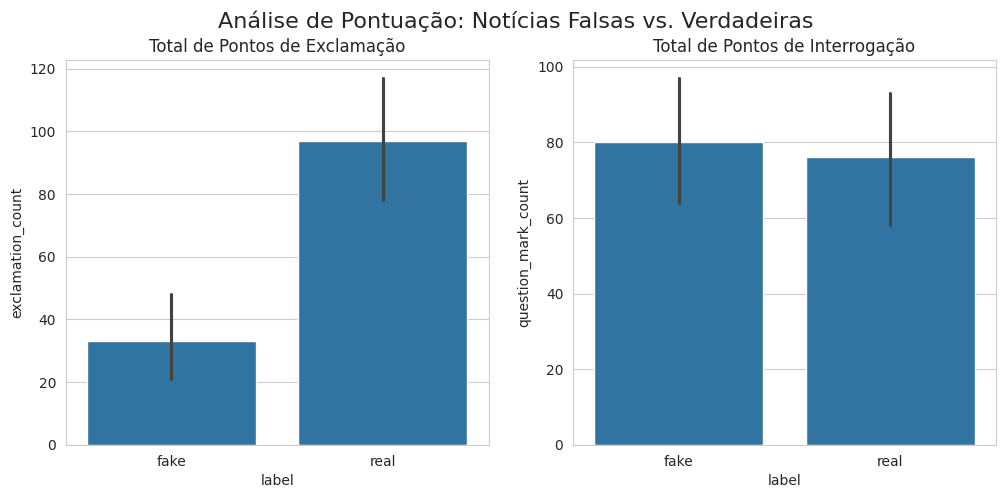


Importância dos Atributos para Diferenciar Fake News (com pontuação):
               feature  importance
0           word_count         0.0
1           char_count         0.0
2           adjectives         0.0
3              adverbs         0.0
4   sentiment_compound         0.0
5    exclamation_count         0.0
6  question_mark_count         0.0


In [ ]:
# Análise e Modelo para Fake vs. Verdadeira

print("--- Parte 1: Análise e Modelo para Fake vs. Verdadeira ---")

# Adicionar os novos atributos à lista de features
features = ['word_count', 'char_count', 'adjectives', 'adverbs', 'sentiment_compound', 'exclamation_count', 'question_mark_count']

# Gráficos
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Análise de Pontuação: Notícias Falsas vs. Verdadeiras', fontsize=16)
sns.barplot(ax=axes[0], x='label', y='exclamation_count', data=df_main, estimator=sum)
axes[0].set_title('Total de Pontos de Exclamação')
sns.barplot(ax=axes[1], x='label', y='question_mark_count', data=df_main, estimator=sum)
axes[1].set_title('Total de Pontos de Interrogação')
plt.show()


# Modelo Auxiliar
X = df_main[features]
y = df_main['label_numeric']
X = X[y.notna()]
y = y[y.notna()]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Importância dos Atributos
feature_importances = pd.DataFrame({'feature': features, 'importance': rf_model.feature_importances_}).sort_values('importance', ascending=False)
print("\nImportância dos Atributos para Diferenciar Fake News (com pontuação):")
print(feature_importances)



--- Parte 2: Análise da Rotulação Humana de 'Apelo' ---


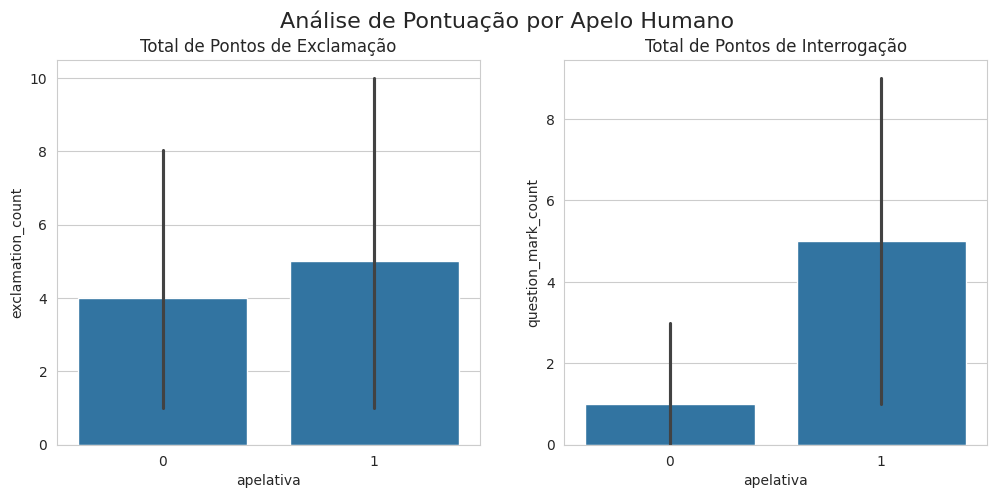


Importância dos Atributos para Identificar um Título Apelativo (com pontuação):
               feature  importance
1           char_count    0.326307
0           word_count    0.244736
4   sentiment_compound    0.219099
2           adjectives    0.105504
3              adverbs    0.055206
6  question_mark_count    0.034386
5    exclamation_count    0.014763


In [ ]:
# Análise e Modelo para Apelativa vs. Não Apelativa

print("\n\n--- Parte 2: Análise da Rotulação Humana de 'Apelo' ---")

# Adicionar os novos atributos à lista de features
features_apelativa = ['word_count', 'char_count', 'adjectives', 'adverbs', 'sentiment_compound', 'exclamation_count', 'question_mark_count']

# Gráficos
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Análise de Pontuação por Apelo Humano', fontsize=16)
sns.barplot(ax=axes[0], x='apelativa', y='exclamation_count', data=df_rotulado, estimator=sum)
axes[0].set_title('Total de Pontos de Exclamação')
sns.barplot(ax=axes[1], x='apelativa', y='question_mark_count', data=df_rotulado, estimator=sum)
axes[1].set_title('Total de Pontos de Interrogação')
plt.show()

# Modelo para Prever o Apelo
X_apelativa = df_rotulado[features_apelativa]
y_apelativa = df_rotulado['apelativa']
X_apelativa = X_apelativa[y_apelativa.notna()]
y_apelativa = y_apelativa[y_apelativa.notna()]
X_train_ap, X_test_ap, y_train_ap, y_test_ap = train_test_split(X_apelativa, y_apelativa, test_size=0.3, random_state=42, stratify=y_apelativa)
rf_apelativa_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_apelativa_model.fit(X_train_ap, y_train_ap)

# Importância dos Atributos para Apelo
feature_importances_apelativa = pd.DataFrame({'feature': features_apelativa, 'importance': rf_apelativa_model.feature_importances_}).sort_values('importance', ascending=False)
print("\nImportância dos Atributos para Identificar um Título Apelativo (com pontuação):")
print(feature_importances_apelativa)

In [ ]:
# Classificação em Massa

print("--- Parte 3: Classificação em Massa do Dataset Principal ---")

# Utilizando os dados rotulados para treinar
features_apelativa = ['word_count', 'char_count', 'adjectives', 'adverbs', 'sentiment_compound', 'exclamation_count', 'question_mark_count']
X_total_humanos = df_rotulado[features_apelativa]
y_total_humanos = df_rotulado['apelativa']

# Garantir que não há valores nulos
X_total_humanos = X_total_humanos[y_total_humanos.notna()]
y_total_humanos = y_total_humanos[y_total_humanos.notna()]

# Criamos e treinamos o modelo final com todos os dados rotulados.
modelo_final_apelativa = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_final_apelativa.fit(X_total_humanos, y_total_humanos)

print("Modelo final treinado com todos os dados humanos.")

# Garantir que o df_main tenha as mesmas features.
X_main_para_prever = df_main[features_apelativa]

# Usar o modelo treinado para prever os rótulos no dataset principal.
df_main['apelativa_predita'] = modelo_final_apelativa.predict(X_main_para_prever)

print(f"Classificação concluída! {sum(df_main['apelativa_predita'])} notícias foram classificadas como apelativas.")
print(df_main[['title', 'label', 'apelativa_predita']].head())

--- Parte 3: Classificação em Massa do Dataset Principal ---
Modelo final treinado com todos os dados humanos.
Classificação concluída! 1015 notícias foram classificadas como apelativas.
                                                   title label  \
4291   Will Bindi Irwin Get Married to Boyfriend Chan...  fake   
14922  Bob Harper: Howard Stern Reached Out to Me Aft...  real   
19868  'Guardians of the Galaxy Vol. 2' cast play Gue...  real   
12669  'The X-Files': What Did Scully Whisper to Mulder?  real   
12570  'Today': Ratings show replacing Matt Lauer wit...  real   

       apelativa_predita  
4291                   1  
14922                  0  
19868                  1  
12669                  1  
12570                  0  



--- Parte 4: Análise Final em Larga Escala ---

Análise Cruzada: Fake/True vs. Apelativa/Não Apelativa
apelativa_predita     0    1
label                       
fake                302  268
real               1003  747


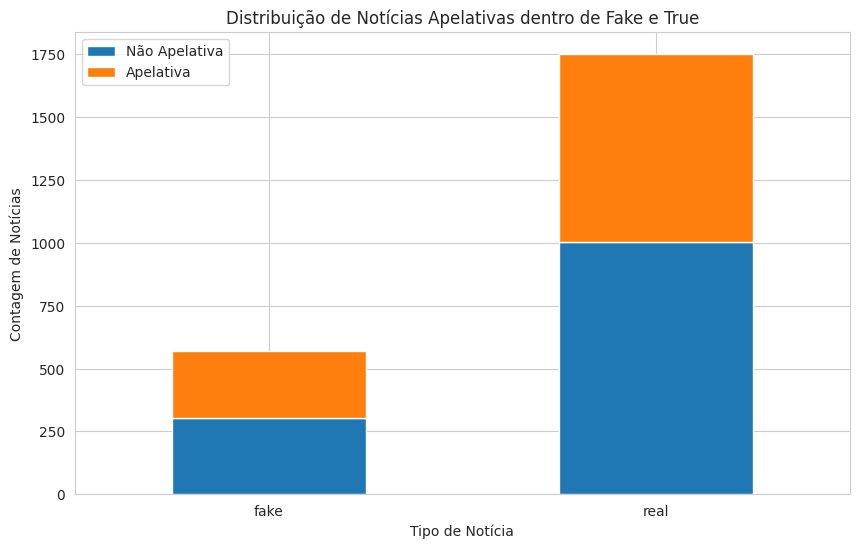


Análise Percentual:
apelativa_predita      0      1
label                          
fake               52.98  47.02
real               57.31  42.69


In [ ]:
# Análise Final

print("\n--- Parte 4: Análise Final em Larga Escala ---")

# Cruzando as informações de Fake News com Apelo
analise_cruzada = pd.crosstab(df_main['label'], df_main['apelativa_predita'])
print("\nAnálise Cruzada: Fake/True vs. Apelativa/Não Apelativa")
print(analise_cruzada)

# Visualizando a proporção
analise_cruzada.plot(kind='bar', stacked=True, figsize=(10, 6), rot=0)
plt.title('Distribuição de Notícias Apelativas dentro de Fake e True')
plt.xlabel('Tipo de Notícia')
plt.ylabel('Contagem de Notícias')
plt.legend(['Não Apelativa', 'Apelativa'])
plt.show()

# Calculando a porcentagem
porcentagem = analise_cruzada.div(analise_cruzada.sum(axis=1), axis=0) * 100
print("\nAnálise Percentual:")
print(porcentagem.round(2))

In [ ]:
# Teste de Significância Estatística (Qui-Quadrado)

from scipy.stats import chi2_contingency

print("--- Teste Qui-Quadrado de Independência ---")

# A função chi2_contingency precisa da tabela de contagem de frequência (não de porcentagem).
# Felizmente, já criamos essa tabela na célula anterior e a chamamos de 'analise_cruzada'.
print("Tabela de Contingência (Contagens):")
print(analise_cruzada)

# Realizar o teste
chi2, p_valor, dof, expected = chi2_contingency(analise_cruzada)

print(f"\nEstatística Qui-Quadrado: {chi2:.4f}")
print(f"P-valor do teste: {p_valor:.4f}")

# Interpretar o p-valor
alpha = 0.05
print(f"\nNível de significância (alpha): {alpha}")

--- Teste Qui-Quadrado de Independência ---
Tabela de Contingência (Contagens):
apelativa_predita     0    1
label                       
fake                302  268
real               1003  747

Estatística Qui-Quadrado: 3.1048
P-valor do teste: 0.0781

Nível de significância (alpha): 0.05
